## XGBoost

We are using the XGBoost package (https://xgboost.readthedocs.io/en/latest/index.html , version 1.5.0) in this notebook .We will use XGBClassifier to solve the classification problem which we predict wether a PA form will be approved base on information provided on the PA form. Our data features are 'correct_diagnosis', 'tried_and_failed', 'contraindication', 'drug'(drug type), 'bin'(payer id),'reject_code', which are all categorical. Our label will be 'pa_approved'. 

In [1]:
#import pacakges
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
#read data
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()
X_train,X_test,Y_train,Y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

## Baseline:
We predoct that all PA form will be approved. In this case the true positive rate = false positive rate = 1, the ROC-AUC score of our baseline model is 0.5. The error of this predictor is 100-73.445 = 26.555.

## XGBClassifier
We will using GBTree booster; our learning objective (objective to solve during the optimization problem) is  logloss for binary regression; we will tune our parameters based on the accuracy and roc-auc scores.

We will explore the performance of the algorithm for:  
tree_method to be 'approx' or 'hist'  
max_depeth to be 1, 2, or 3  
subsample rate to be 0.5, 0.8, 1  
n_estimators up to 90  
eta to be 0.1,0.5,1,3,7,10  

We are going to use the GridSearchCV from sklearn to perform hyperparameter tuning. 

In [3]:
tuned_parameters = {'booster': ['gbtree'], 'objective': ['binary:logistic'], 'max_depth': [1,2,3],
             'subsample': [0.5,0.8,1], 'tree_method': ['approx','hist'],
             'n_estimators': [90], 'eta': [0.1,0.5,1,3,7,10],'use_label_encoder': [False]}
scores = ['accuracy','roc_auc']
xgb_clf= xgb.XGBClassifier(eval_metric = 'auc')
skf = StratifiedKFold(n_splits=5,random_state=10475, shuffle=True)
for scr in scores:
    print("# Tuning hyper-parameters for %s" % scr)
    print()
    clf_tun = GridSearchCV(xgb_clf, tuned_parameters, scoring="%s" % scr,cv = skf)
    clf_tun.fit(X_train, Y_train)
    print("Best parameters set found based on the parameter set:")
    print()
    print(clf_tun.best_params_)
    print("Grid scores on parameter set:")
    print()
    means = clf_tun.cv_results_["mean_test_score"]
    stds = clf_tun.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf_tun.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r \n" % (mean, std * 2, params))
    print()
 

# Tuning hyper-parameters for accuracy

Best parameters set found based on the parameter set:

{'booster': 'gbtree', 'eta': 1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.5, 'tree_method': 'hist', 'use_label_encoder': False}
Grid scores on parameter set:

0.802 (+/-0.008) for {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.5, 'tree_method': 'approx', 'use_label_encoder': False} 

0.800 (+/-0.002) for {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.5, 'tree_method': 'hist', 'use_label_encoder': False} 

0.800 (+/-0.002) for {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.8, 'tree_method': 'approx', 'use_label_encoder': False} 

0.800 (+/-0.002) for {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logisti

Best parameters set found based on the parameter set:

{'booster': 'gbtree', 'eta': 1, 'max_depth': 3, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 1, 'tree_method': 'approx', 'use_label_encoder': False}
Grid scores on parameter set:

0.871 (+/-0.003) for {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.5, 'tree_method': 'approx', 'use_label_encoder': False} 

0.871 (+/-0.003) for {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.5, 'tree_method': 'hist', 'use_label_encoder': False} 

0.872 (+/-0.002) for {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.8, 'tree_method': 'approx', 'use_label_encoder': False} 

0.872 (+/-0.002) for {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.8, 'tree_method': 'hi

From the detailed performance matrix, we can notice that quite a lot of algorithm have similar performance.

Best parameters set found based on the parameter set:

{'booster': 'gbtree', 'eta': 1, 'max_depth': 1, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 0.5, 'tree_method': 'hist', 'use_label_encoder': False}

Best parameters set found based on the parameter set:

{'booster': 'gbtree', 'eta': 1, 'max_depth': 3, 'n_estimators': 90, 'objective': 'binary:logistic', 'subsample': 1, 'tree_method': 'approx', 'use_label_encoder': False}

Now we would like to re-fit our model using the two set of parameters found above on the entire training set, and see the performance on the test sets. 

In [11]:
xgb_clf= xgb.XGBClassifier(booster = 'gbtree',objective = 'binary:logistic',max_depth = 1,subsample = 0.5,
                           tree_method = 'hist', n_estimators= 90,
                           eta = 1, use_label_encoder=False,eval_metric = 'error')
xgb_clf.fit(X_train,Y_train,eval_set = [(X_train,Y_train)],verbose = False)
Y_pred = xgb_clf.predict(X_train)
print(classification_report(Y_train, Y_pred))
print('Accuacy score of this set of parameter is: ', accuracy_score(Y_train, Y_pred),'\n')
print('ROC-AUC score of this set of parameter is: ', roc_auc_score(Y_train, Y_pred),'\n')

              precision    recall  f1-score   support

           0       0.72      0.49      0.58    118105
           1       0.83      0.93      0.88    326655

    accuracy                           0.81    444760
   macro avg       0.78      0.71      0.73    444760
weighted avg       0.80      0.81      0.80    444760

Accuacy score of this set of parameter is:  0.8141739365050814 

ROC-AUC score of this set of parameter is:  0.7101437502297483 



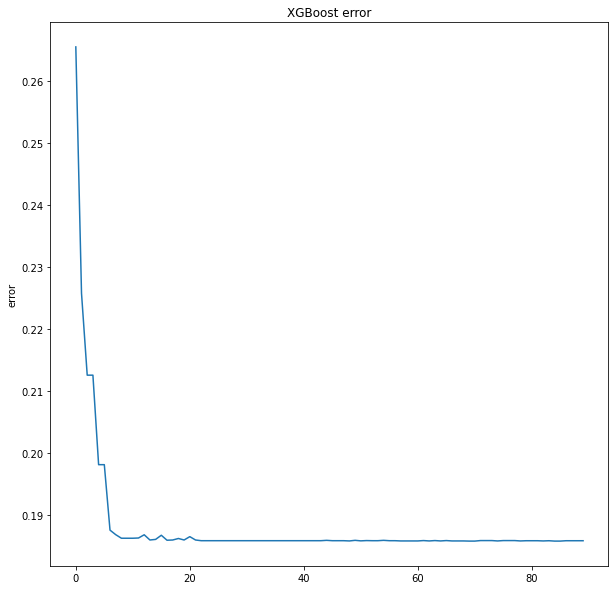

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10))
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
plt.plot(x_axis, results['validation_0']['error'], label='Train_all')
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

In [13]:
xgb_clf_r= xgb.XGBClassifier(booster = 'gbtree',objective = 'binary:logistic',max_depth = 3,subsample = 1,
                           tree_method = 'approx', n_estimators= 90,
                           eta = 1, use_label_encoder=False,eval_metric = 'auc')
xgb_clf_r.fit(X_train,Y_train,eval_set = [(X_train,Y_train)],verbose = False)
Y_pred = xgb_clf_r.predict(X_train)
print(classification_report(Y_train, Y_pred))
print('Accuacy score of this set of parameter is: ', accuracy_score(Y_train, Y_pred),'\n')
print('ROC-AUC score of this set of parameter is: ', roc_auc_score(Y_train, Y_pred),'\n')

              precision    recall  f1-score   support

           0       0.71      0.50      0.59    118105
           1       0.84      0.93      0.88    326655

    accuracy                           0.81    444760
   macro avg       0.77      0.72      0.74    444760
weighted avg       0.80      0.81      0.80    444760

Accuacy score of this set of parameter is:  0.8141851785232485 

ROC-AUC score of this set of parameter is:  0.715330072034963 



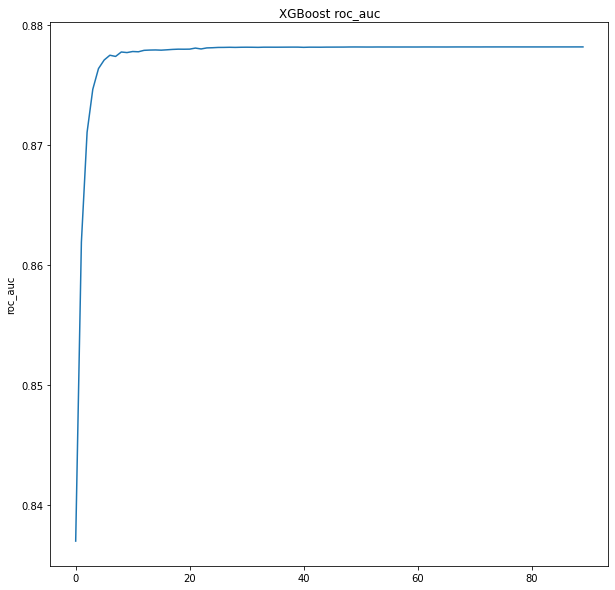

In [14]:
figure(figsize=(10, 10))
results = xgb_clf_r.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
plt.plot(x_axis, results['validation_0']['auc'], label='Train_all')
plt.ylabel('roc_auc')
plt.title('XGBoost roc_auc')
plt.show()

Sice the ROC-AUC scores have ~ 15% difference for the training and testing data, there might be overfit.   
The accuracy score are similar tough. 